# Support vector machines (SVMs)

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from addutils import css_notebook
css_notebook()

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

## 1 Introduction

*Support vector machines (SVMs)* is a supervised learning algorithm, primarily designed for classification that has been for a long period of time one of the most successful algorithm in ML. They are a good method because there is an intuition behind their formulation and the algorithm can be solved with optimization, and the solution can be interpreted intuitively.

In the following section we will introduce the following notions:
- Maximizing the margin
- The solution
- Kernel trick
- Soft margin SVMs

### 1.1 Better Linear Separation

Suppose that you have a dataset with linearly separable data. 

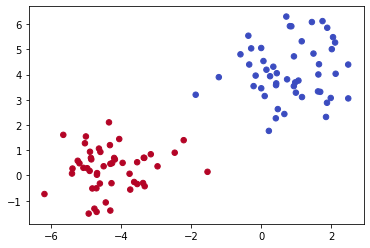

In [5]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2, random_state=3, cluster_std=0.99)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')

You could use several separating lines. 

(-2.0101170441814227, 6.799524300998446)

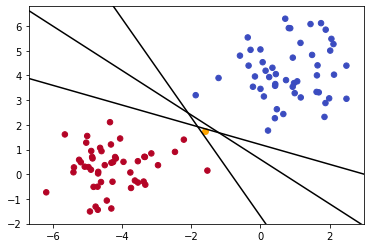

In [6]:
xfit = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')
ax.plot([-1.6], [1.75], '.', color='orange', markeredgewidth=2, markersize=10)
fits = [(-2, -1.7), (-0.4, 1.2), (-0.9, 0.6)]
for m, b in fits:
    ax.plot(xfit, m * xfit + b, '-k')
ax.set_xlim(X[:,0].min()-0.5, X[:,0].max()+0.5)
ax.set_ylim(X[:,1].min()-0.5, X[:,1].max()+0.5)

If I look at the lines we can see their margin, we can ask ourselves, if I move the line a bit when is it too close than it can crossover (that is making an error)?

(-2.0101170441814227, 6.799524300998446)

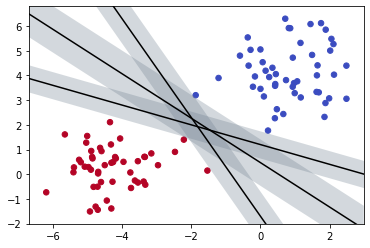

In [7]:
xfit = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')
fits = [(-2, -1.7, 1.), (-0.4, 1.2, 0.55), (-0.9, 0.47, .94)]
for m, b, d in fits:
    yfit = m * xfit + b
    ax.plot(xfit, yfit, '-k')
    ax.fill_between(xfit, yfit - d, yfit + d, lw=0,
                    edgecolor='none', color='slategrey', alpha=0.3)
ax.set_xlim(X[:,0].min()-0.5, X[:,0].max()+0.5)
ax.set_ylim(X[:,1].min()-0.5, X[:,1].max()+0.5)

*Which line (margin) is the best?*

It is tempting to say that bigger margin is better. Suppose you have a process that generates the data that has some noise. If the margin is bigger there could be more chance to correctly classify noisy data.

Two question are worth answering:
- Why bigger margin is better?
- Which $w$ maximize the margin?

### 1.2 Bigger margin is better

Suppose we want to classify a set of three points in the plane, using a line. A single line can separate all possible combinations of points?

<img src="images/dichotomies.png" alt="Dichotomies" height="500" width="500"> 

Yes, it can. In a sense it has a low bias, all possible functions that can generate those three points can be learned. But this could be bad (remeber bias variance tradeoff?) and can lead to bad generalization.

If we can restrict the line to be the ones that have fat margin? Can we increase the bias (decrease variance) and generalize better?

<img src="images/dichotomies_fat.png" alt="Dichotomies fat margin" height="500" width="500">

Suppose you can use only the lines that have a margin with at least a specific (fat) size to accept it. By putting a restriction on the dimension of the margin the model gets simpler (higher bias).

(Actually this example refers to the theory of [**VC dimension**](https://en.wikipedia.org/wiki/VC_dimension))

### 1.3 Find the plane with bigger margin

<img src="images/maximize_margin.png"  alt="Margins" height="500" width="500">

Recall that the distance from a point($x_0 ,y_0)$ to a line $Ax+By+c = 0$ is: 

$$\frac{\mid A x_0 + B y_0 +c \mid}{\sqrt{(A^2 +B^2)}}$$

The distance between H and H1 is:

$$\frac{\mid w\cdot x+b \mid }{\|w\|}=\frac{1}{\|w\|}$$

The distance between H1 and H2 is: 

$$\frac{2}{\|w\|}$$

In order to maximize the margin, we need to minimize $\|w\|$, with the condition that there are no datapoints between H1 and H2:

$$
x_i \cdot w+b \geq +1 \rightarrow y_i =+1\\
x_i \cdot w+b \leq -1 \rightarrow y_i =-1
$$

Can be combined into 

$$y_i (x_i \cdot w + b) \geq 1$$

The maximal margin touches some of the points, but it does not have points inside. The points that do not lie to either side of the margin are called interior points.

The problem is: minimize $\|w\|$, such that discrimination boundary is obeyed, i.e., min f(x) s.t. g(x)=0, where:

$$
f: \frac{1}{2} \|w\|^2 \\
g: y_i (x_i \cdot w)+b = 1 \quad or \quad [y_i (x_i \cdot w)+b] - 1 =0
$$

This is a constrained optimization problem that can be solved by Lagrangian multipler method and quadratic programming. We will not dig into the mathematical details of the solution because it will require a lot of time with many passages, please refer to [this](https://www.svm-tutorial.com/) if you want all the details. We will only sketch the solution because we will use it later on for the derivation of the kernel method and the soft margin version of SVM.

This is the formulation of the lagrangian multiplier method:

$$L ( x , \alpha ) = f ( x ) + \sum_i \alpha_i g_i ( x )$$ 

$f(x)$ is the gradient max of $f$ and $g$ is the constraint condition. In our case, $f(x): \frac{1}{2}\|w\|^2$ and $g(x): y_i (w\cdot x_i +b)-1=0$ so the (primal) Lagrangian for SVM is:

$$
\mathcal{L}(w,b,\alpha) \equiv \frac{1}{2}\|w\|^2 - \sum_i \alpha_i y_i (x_i \cdot w + b) + \sum_i \alpha_i \\
\alpha_i \geq 0,\quad \forall i
$$

Putting the derivatives equal to zero we get:
$$
w = \sum_i \alpha_i y_i x_i, \quad \sum_i \alpha_i y_i = 0 \\
$$

In order to solve this maximization problem we have to switch to its dual formulation. Substituting the gradient and the constraint in the lagrangian we obtain:

$$
\mathcal{L}(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_j \sum_i y_j y_i \alpha_j \alpha_i  x_j \cdot x_i   
$$

subject to:

$$
\alpha_i \geq 0, \quad \sum_i \alpha_i y_i = 0
$$

This is a simple quadratic form in the vector alpha. $w$ does not appear in optimization so it is only the result (that is I find alphas and then compute $w$).

The solution of this optimization is quadratic programming. There are packages already available for solving quadratic programming problems, but we have to switch to a minimization problem. This is easily done by changing the sign of the equation. 

$$
\underset{\alpha}min \quad  \frac{1}{2} \alpha \cdot Q \alpha - 1 \cdot \alpha
$$

subject to:

$$
\alpha_i \geq 0, \quad \alpha \cdot y = 0
$$

where Q is the matrix of quadratic coefficients (and the vector $-1$ is the linear term):

\begin{bmatrix}
y_1y_1\,X_1^TX_1 & y_1y_2\,X_1^TX_2 & \cdots & y_1y_n\,X_1^TX_n \\
y_2y_1\,X_2^TX_1 & y_2y_2\,X_2^TX_2 & \cdots & y_2y_n\,X_2^TX_n \\
\cdots & \cdots & \cdots & \cdots \\
y_ny_1\,X_n^TX_1 & y_ny_2\,X_n^TX_2 & \cdots & y_ny_n\,X_n^TX_n \\
\end{bmatrix}

the quadratic programming package will take the matrix of coefficient and return the vector of alphas that minimize that quantity. The vector of alphas has the same lenght as the number of examples. The vector comes with a surprise, most of the alphas are zero!

Now we want to get the solution, that is the vector of $w$, remember? Our separating hyperplane. How do we get that? By plugging alphas in the equation 

$$w = \sum_i \alpha_i y_i x_i$$

The problem formulation has a nice condition, the quantity:

$$\alpha_i ( y_i (x_i \cdot w + b) - 1) = 0$$

so either the alpha is zero or the remaining term is zero! If the other term is positive, we are talking about an interior point, this equation guaranties that the corresponding alpha is zero. If in the other case alpha is positive the corresponding point is called **support vector**!

$\alpha_i > 0 \implies x_i$ is a **support vector**

In [8]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [9]:
def plot_separating_hyperplane(model, ax, plot_support=True):
    """Plot the decision function for a two-dimensional SVC"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()    
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1], edgecolors='k', 
                   s=200, linewidth=1, facecolors='none')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return

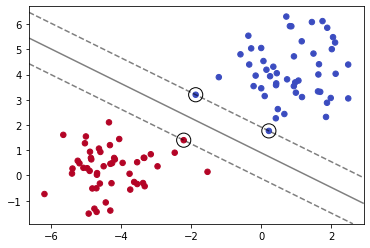

In [10]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')
plot_separating_hyperplane(model, ax)

**IMPORTANT** The number of support vectors is determinant for the generalization result of the model!

It can be proven that:

$$\mathbb{E}[E_{test}] \le \frac{\mathbb{E}[\text{# of SV's}]}{N-1}$$

### 1.4 Non-separable cases

We talk about separable data all the time, but what happens when the data it is not separable? There are roughly two kind of non-separable data.

The data could be **sligthly** non-separable like in the picture below:

<img src="images/non_separable_svm2.png"  alt="Margins" height="400" width="400">

I don't want to add nonlinear features to go to a high dimensional nonlinear space just for these two items. If there could be a method that accepts some errors during training, that would be perfect, because the generalization would be better instead of insisting to make zero error and then generalize bad because we are using overly complex method.

Another case is when the data is **seriously** non separable. Then you should apply a nonlinear transformation. 

<img src="images/non_separable_svm1.png"  alt="Margins" height="500" width="500">

We will shortly see how to deal with both cases. For slightly non-separable data we will use **soft margin SVM**, for seriously non-separable data we will use the **Kernel**. 

In real life applications, when you deal with a practical dataset the chances are that the dataset will have aspects of both. It will have a built in non linearity and still some annoying points will be out of there testing your learning ability. Therefore you will be combining the kernel and the soft margin SVM in almost all the problem you will face.

### 1.5 Kernel Trick




This formulation albeit interesting leaves us with one question. How do I apply SVM to the nonlinear case? 

Recall linear regression. In order to go nonlinear we had to transform the features. That is we passed from a feature space $\mathcal{X}$ to a feature space $\mathcal{Z}$. Can we apply the same transformation to the SVM? How does the problem formulation changes?

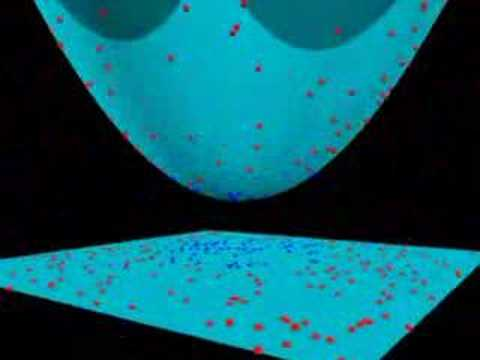

In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA', width=800, height=420)

$$\mathcal{L}(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_j \sum_i y_j y_i \alpha_j \alpha_i  z_j \cdot z_i$$

Suppose that the new space has higher dimension. Does it change the equation? No, because it is an inner product. We have only one number at the end! The number of alphas (the number of data points) remains the same. The $w$ however will belong to the $\mathcal{Z}$ space. Do I have also the support vector in the $\mathcal{X}$? They are not support vector any more, they are called "pre-images" of support vector (they are the closest to the margin) but the margin is maintained in the $\mathcal{Z}$ space.

The nice thing about this is: we don't need to compute the vectors $z_i$ and $z_j$ in the $\mathcal{Z}$ space but only the dot product. So the mathematical computation involve $x_i$ and $x_j$ and gives the correct result in $\mathcal{Z}$.

What do I need from the $\mathcal{Z}$ space, so that its dimensionality does not appear? I need to calculate the inner product, $\alpha_i  z_j \cdot z_i$, but the good news is that it is actually less demanding than transforming the vectors in from the $\mathcal{X}$ space. We do not need anything else from the $\mathcal{Z}$ space other than the inner product. Is it true? What about the output of the model?

$$g(x) = sign(w \cdot z + b)$$

but 

$$w = \sum_{z_i \in SV} \alpha_i y_i z_i$$

substituting we need only 

$$z \cdot z_i$$

the same occurs for b, I can use any equation in the form $y_j(w \cdot z_j + b) = 1$ substitute $w$ and again I get $z_j \cdot z_i$

I can even move forward. Now I'm computing the inner product without visiting the $\mathcal{Z}$ space, but I can compute the inner product even without knowing what the $\mathcal{Z}$ space is. 

Now let's see how to do that. We define the **kernel** as a generalized inner product, that is an inner product after a transformation:

$$z \cdot z' = K(x, x')$$

\begin{bmatrix}
y_1y_1\,K(X_1,X_1) & y_1y_2\,K(X_1,X_2) & \cdots & y_1y_n\,K(X_1,X_n) \\
y_2y_1\,K(X_2,X_1) & y_2y_2\,K(X_2,X_2) & \cdots & y_2y_n\,K(X_2,X_n) \\
\cdots & \cdots & \cdots & \cdots \\
y_ny_1\,K(X_n,X_1) & y_ny_2\,K(X_n,X_2) & \cdots & y_ny_n\,K(X_n,X_n) \\
\end{bmatrix}



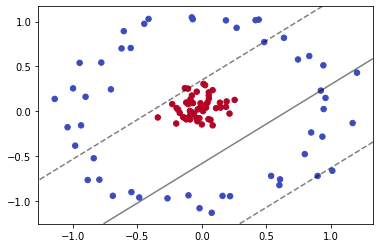

In [12]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1, random_state=3)
clf = SVC(kernel='linear').fit(X, y)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')
plot_separating_hyperplane(clf, ax, plot_support=False)

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

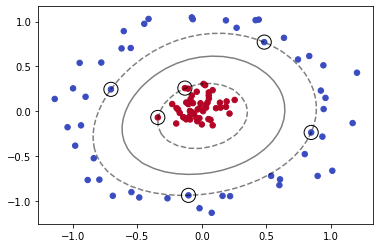

In [14]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='coolwarm')
plot_separating_hyperplane(clf, ax)

### 1.5 Soft margin SVMs

So let's get back to the sligthly non separable case. I want to apply SVM all the same. We get back to the basic case but we are goint to consider errors. Some points are interior to the margin (and some even to the other side of the margin).

How we can do that? We can add and error measure for each margin violation. Why that? Because now I have a notion of margin. It is not important to be on the right side of the margin but *how far* the point is from the margin. Remember? It defines the difference between interior points and support vector!

What does it mean violating the margin and how can I quantify it? 

<img src="images/softmargin_svm.png"  alt="Margins" height="400" width="400">

Suppose a point violate the margin (the green dot inside the margin in the bottom right of the figure above) but I can still classify it correctly. 

I introduce an error term in the equation that defines the classification, for every points  that violate the margin:

$$y_i = (w^Tx_i+b) \geq 1-\xi_i \quad \xi \ge 0$$

The amount of total violation that I have is:

$$\sum_{i=1}^N \xi_i$$

Let's make a step backward. I want to minimize $\frac{1}{2}w^Tw$ in order to maximize the margin. I want to add an error term that corresponds to the violation of the margin.

$$\frac{1}{2}w^Tw + C\sum_{i=1}^N \xi_i$$

Where $C$ is a constant that gives me the relative importance of the error term vs. the minimization term. It is the regularization term. "Regularization" means modifying the optimization problem to prefer small $w$ that in turn gives a bigger margin!

The optimization problem is then trading off how fat it can make the margin versus how many points have to be moved around to allow this margin. The margin can be less than 1 for a point $x_i$ by setting $\xi_i > 0$, but then one pays a penalty of $C\xi_i$ in the minimization for having done that. 

The sum of the $\xi_i$ gives an upper bound on the number of training errors. 

As $C$ becomes large, it is unattractive to not respect the data at the cost of reducing the geometric margin. For example if $C = \infty$ we are not allowed to make errors and we get back to the hard margin.

When $C$ is small, it is easy to account for some data points with the use of slack variables and to have a fat margin placed so it models the bulk of the data. 

The solution thus become:
$$
\underset{\alpha}min \quad  \frac{1}{2} \alpha \cdot Q \alpha - 1 \cdot \alpha
$$

subject to:

$$
0 \leq \alpha_i \leq C  \quad \alpha \cdot y = 0
$$

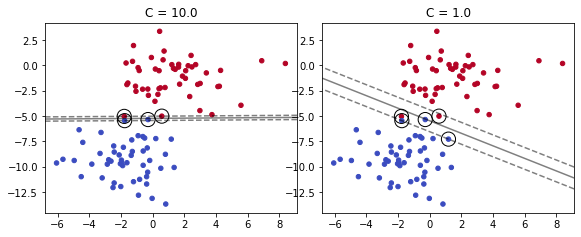

In [15]:
X, y = make_blobs(n_samples=100, centers=2, random_state=2, cluster_std=1.8)
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
fig.subplots_adjust(left=0.01, right=0.99, wspace=0.1)
for axi, C in zip(ax, [10.0, 1.0]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')
    plot_separating_hyperplane(model, axi)
    axi.scatter(model.support_vectors_[:, 0], 
                model.support_vectors_[:, 1],
                s=100, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=12)

### 1.6 Advantages and Disadvantages

**Advantages**:
- "The key features of SVMs are the use of kernels, the absence of local minima, the sparseness of the solution and the capacity control obtained by optimising the margin." Shawe-Taylor and Cristianini (2004) 

**Disadvantages**:
- "Perhaps the biggest limitation of the support vector approach lies in choice of the kernel." Burgess (1998)

- "A second limitation is speed and size, both in training and testing." Burgess (1998)

- "Discrete data presents another problem..." Burgess (1998)

- "...the optimal design for multiclass SVM classifiers is a further area for research." Burgess (1998)

- "Although SVMs have good generalization performance, they can be abysmally slow in test phase, a problem addressed in (Burges, 1996; Osuna and Girosi, 1998)." Burgess (1998)

- "Besides the advantages of SVMs - from a practical point of view - they have some drawbacks. An important practical question that is not entirely solved, is the selection of the kernel function parameters - for Gaussian kernels the width parameter [sigma] - and the value of [epsilon] in the [epsilon]-insensitive loss function...[more]" Horváth (2003) in Suykens et al.

- "However, from a practical point of view perhaps the most serious problem with SVMs is the high algorithmic complexity and extensive memory requirements of the required quadratic programming in large-scale tasks." Horváth (2003) in Suykens et al. p 392

## 2 SVM for Classification

`SVC and NuSVC` are similar methods, but accept slightly different sets of parameters and have different mathematical formulations (see section Mathematical formulation). `LinearSVC` is another implementation of Support Vector Classification for the case of a linear kernel.

In [16]:
from sklearn import svm, datasets

iris = datasets.load_iris()
print(iris.feature_names)
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
h = .02               # step size in the mesh
C = 1.0               # SVM regularization parameter

std_svc = svm.SVC(kernel='linear', C=C).fit(X,y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X,y)
pol_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X,y)
lin_svc = svm.LinearSVC(C=C).fit(X,y)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
import addutils.palette as pal
import seaborn as sns
from bokeh.models.mappers import LinearColorMapper

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xs = np.arange(x_min, x_max, h*2)
ys = np.arange(y_min, y_max, h*2)
xx, yy = np.meshgrid(xs, ys)
xx = xx.ravel()
yy = yy.ravel()

titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'LinearSVC (linear kernel)']

grid = []
palette = list(map(pal.to_hex, sns.color_palette('Paired', 6)))
palette_dots = palette[1::2]    # colours in odd indices 
palette_patches = palette[::2]  # colours in even indices
# Bokeh understands the mapping interval for the colors as open on the high side.
# So we have to customize the color mapper, and raise the upper limit a bit
# to prevent Bokeh from discarding any colours. 
# max(Z) is 2, so 2.1 is fine for the upper limit.
patches_cmapper = LinearColorMapper(low=0, high=2.1, palette=palette_patches)

for i, clf in enumerate((std_svc, rbf_svc, pol_svc, lin_svc)):
    # Plot the decision boundary assigning a color to each point in the mesh
    Z = clf.predict(np.c_[xx, yy])
    Z = Z.reshape((ys.size, xs.size))
    
    # Plot the training points
    fig = bk.figure(plot_width=360, plot_height=280, title=titles[i],
                   x_range=(x_min, x_max), y_range=(y_min, y_max))
    fig.title.text_font_size = '10pt'
    fig.axis.major_label_text_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.minor_tick_line_color = None
    fig.image(image=[Z*0.99 + 0.1], x=[x_min], y=[y_min], 
              dw=[x_max-x_min], dh=[y_max-y_min],
              color_mapper=patches_cmapper)
    fig.scatter(X[:, 0], X[:, 1], size=6,
                line_color='black', line_alpha=0.5,
                fill_color=[ palette_dots[j] for j in y ])
    grid.append(fig)
    
bk.show(bk.gridplot([[grid[0], grid[1]], [grid[2], grid[3]]]))

## 3 SVM for Regression

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.

As with classification classes, the fit method will take as argument vectors X, y, only that in this case y is expected to have floating point values instead of integer values:

In [18]:
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
svm_svr = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                  epsilon=0.1, gamma='auto', kernel='rbf',
                  shrinking=True, tol=0.01, verbose=False)
svm_svr.fit(X, y) 
svm_svr.predict([[1, 1]])

array([1.5])

**Support Vector Regression (SVR) using linear and non-linear kernels:** this is a simple example of 1D regression using linear, polynominial and RBF kernels.



In [19]:
# Generate data and add noise to target
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))

# Fit regression model
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

# look at the results
fig = bk.figure(plot_width=600, plot_height=500, title="Support Vector Regression")
fig.title.text_font_size = '12pt'
fig.scatter(X[:,0], y, color='black', legend='data', size=8)
fig.line(X[:,0], y_rbf, color='green', legend='RBF model')
fig.line(X[:,0], y_lin, color='red', legend='Linear model')
fig.line(X[:,0], y_poly, color='blue', legend='Polynomial model')
fig.xaxis.axis_label = 'data'
fig.yaxis.axis_label = 'target'
fig.axis.axis_label_text_font_size = '11pt'
bk.show(fig)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 4 Novelty detection

Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). Often, this ability is used to clean real data sets. In novelty detection the training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

An example using a one-class SVM for novelty detection.

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

Consider a data set of n observations from the same distribution described by p features. Consider now that we add one more observation to that data set. Is the new observation so different from the others that we can doubt it is regular? (i.e. does it come from the same distribution?) Or on the contrary, is it so similar to the other that we cannot distinguish it from the original observations? This is the question addressed by the novelty detection tools and methods.

In general, it is about to learn a rough, close frontier delimiting the contour of the initial observations distribution, plotted in embedding p-dimensional space. Then, if further observations lay within the frontier-delimited subspace, they are considered as coming from the same population than the initial observations. Otherwise, if they lay outside the frontier, we can say that they are abnormal with a given confidence in our assessment.

In [20]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

In [21]:
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [22]:
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

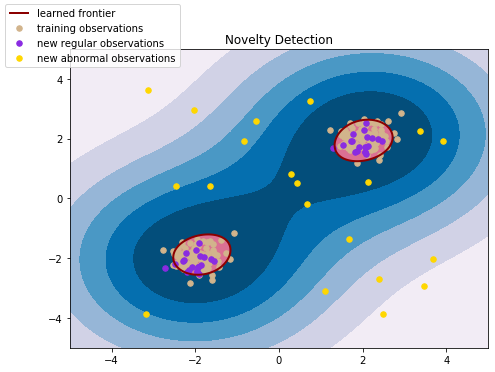

In [23]:
fig, ax = plt.subplots(figsize=(7.5, 5.5))
ax.set_title("Novelty Detection")
ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 30
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], c='tan', s=s)
b2 = ax.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
c = ax.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
ax.axis('tight')
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
fig.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",)

In [24]:
print("error train: %d/200 ; errors novel regular: %d/40 ; errors novel abnormal: %d/40" 
      % (n_error_train, n_error_test, n_error_outliers))

error train: 18/200 ; errors novel regular: 2/40 ; errors novel abnormal: 0/40


---

Visit [www.add-for.com](<http://www.add-for.com/>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.